<a href="https://colab.research.google.com/github/vithika-karan/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition_Vithika_Karan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.
Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

###**Project Problem Statement**
We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.
The solution to this problem is by recognizing facial emotions.
This is a few shot learning live face emotion detection system. The model should be able to real-time
identify the emotions of students in a live class.

In [44]:
#importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
#model building
from keras.models import Sequential
from keras.layers import  Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
#metric
from sklearn.metrics import classification_report
import cv2
import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#reading csv
data = pd.read_csv("/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/fer2013.csv")

In [3]:
#data shape
data.shape

(35887, 3)

In [4]:
#first three rows of the dataset
data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [5]:
#check for null values
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no null values in the dataset.


In [6]:
#lets check the value counts in usage
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
#lets check the value counts in emotion column
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

There are counts for seven emotions. Let's try to explore the images for these classes.

###Exploratory Data Analysis

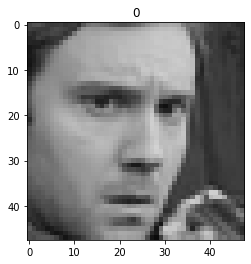

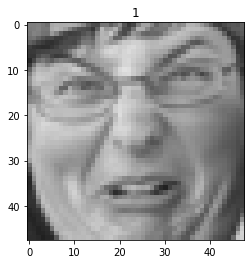

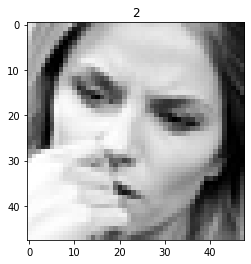

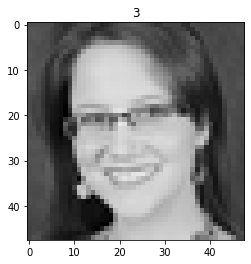

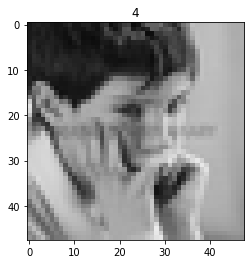

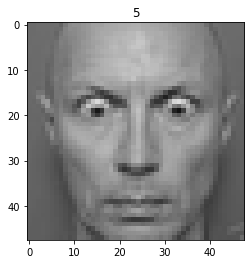

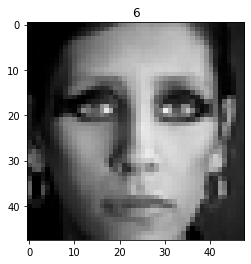

In [8]:
#function to show images of the various emotion classes
def show_img(obs):
  #pass observation and gather pixel and emotion class
  pixels = obs['pixels']
  emotion = obs['emotion']
  #split object and convert to array
  pic = np.array(pixels.split())
  pic = pic.reshape(48,48)
  image = np.zeros((48,48,3))
  #slice image and put the picture in three channels
  image[:,:,0] = pic
  image[:,:,1] = pic
  image[:,:,2] = pic
  #return image array and emotion
  return np.array([image.astype(np.uint8), emotion])

#iterate over all emotions and plot the pixels through the function
for emotion in range(1,8):
    picture = data[data['emotion'] == emotion-1].iloc[0]
    picture = show_img(picture)
    plt.imshow(picture[0])
    plt.title(picture[1])
    plt.show()  

####Data Description
The data consists of grayscale images of faces at a resolution of 48x48 pixels. The faces have been automatically registered such that they are more or less centred in each image and take up around the same amount of area.

The goal is to categorize each face into one of seven categories based on the emotion expressed in the facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). There are 28,709 examples in the training set and 3,589 examples in the public test set.

Text(0.5, 1.0, 'Emotion Distribution')

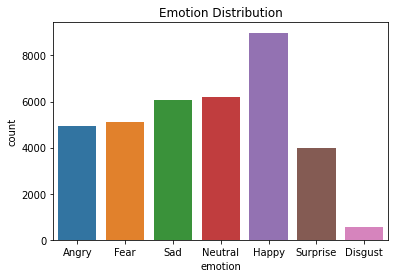

In [9]:
#plotting a bar graph of the emotions
#create dic of emotions
emo_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise',6:'Neutral'}
#creating a copy of data with actual categorial emotions
df1 = data.copy()
df1['emotion'] = df1['emotion'].map(emo_dict)
#plotting
sns.countplot(x=df1['emotion'])
plt.title('Emotion Distribution')

The number of happy pictures are the highest and disgusted pictures lowest in the dataset.

###Data Pre-processing



In [10]:
#splitting the data into train, validation and test set
train_data = data[data['Usage']=='Training']
val_data   = data[data['Usage']=='PublicTest']
test_data  = data[data['Usage']=='PrivateTest']
print("The shape of training set is: {}, \nThe shape of validation set is: {}, \nThe shape of test set is: {}".format(train_data.shape, val_data.shape, test_data.shape))

The shape of training set is: (28709, 3), 
The shape of validation set is: (3589, 3), 
The shape of test set is: (3589, 3)


In [11]:
#reset index
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [12]:
#dropping usage from the datasets
train_data.drop('Usage',axis=1,inplace=True)
val_data.drop('Usage',axis=1,inplace=True)
test_data.drop('Usage',axis=1,inplace=True)

In [13]:
#data splits
X_train, y_train = train_data['pixels'], train_data['emotion']
X_val, y_val = val_data['pixels'], val_data['emotion']
X_test, y_test = test_data['pixels'], test_data['emotion']

The method expects that images belonging to different classes are present in different folders but are inside the same parent folder. 

In [14]:
#main data directory path
path = "/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/Face Emotion Recognition - Vithika Karan/Data & Resources/"
train_path = os.path.join(path,'train')
val_path = os.path.join(path,'valid')

In [13]:
#Create train and validation directories
os.mkdir(train_path)
os.mkdir(val_path)

# Create sub-directories
def emotion_dir(data_path,path,cat):
  ''' The function takes in the data category path and creates directories for different emotion classes'''  
  angry_path = os.path.join(path,data_path,cat+'angry')
  os.mkdir(angry_path)

  fear_path = os.path.join(path,data_path,cat+'fear')
  os.mkdir(fear_path)

  sad_path = os.path.join(path,data_path,cat+'sad')
  os.mkdir(sad_path)

  neutral_path = os.path.join(path,data_path,cat+'neutral')
  os.mkdir(neutral_path)

  happy_path = os.path.join(path,data_path,cat+'happy')
  os.mkdir(happy_path)

  surprise_path = os.path.join(path,data_path,cat+'surprise')
  os.mkdir(surprise_path)

  disgust_path = os.path.join(path,data_path,cat+'disgust')
  os.mkdir(disgust_path)

# train emotions
emotion_dir('train',path,'train-')
# validation directories
emotion_dir('valid',path,'valid-')


In [14]:
#save images
def save_imgs(df,df_path,path,df_cat):
  '''This function takes in the dataframes and creates images and saves images in directories.'''
  
  for i in range(len(df)):
      pixel_string = df['pixels'][i]
      pixels = list(map(int, pixel_string.split()))
      
      matrix = np.array(pixels).reshape(48,48).astype(np.uint8)
      img = Image.fromarray(matrix)

      if df['emotion'][i] == 0:
          img.save(path + df_path + df_cat+'angry/'+df_cat+'angry'+str(i)+'.png')
      elif df['emotion'][i] == 1:
          img.save(path + df_path + df_cat+'disgust/'+df_cat+'disgust'+str(i)+'.png')
      elif df['emotion'][i] == 2:
          img.save(path + df_path + df_cat+'fear/'+df_cat+'fear'+str(i)+'.png')
      elif df['emotion'][i] == 3:
          img.save(path + df_path + df_cat+'happy/'+df_cat+'happy'+str(i)+'.png')
      elif df['emotion'][i] == 4:
          img.save(path + df_path + df_cat+'sad/'+df_cat+'sad'+str(i)+'.png')
      elif df['emotion'][i] == 5:
          img.save(path + df_path + df_cat+'surprise/'+df_cat+'surprise'+str(i)+'.png')
      elif df['emotion'][i] == 6:
          img.save(path + df_path + df_cat+'neutral/'+df_cat+'neutral'+str(i)+'.png')

#train images
save_imgs(train_data,'train/',path,'train-')

In [15]:
#validation images
save_imgs(val_data,'valid/',path,'valid-')

In [15]:
#Image preprocessing
from keras.preprocessing.image import ImageDataGenerator
#Initialising the generators for the train and validation set
#The rescale parameter ensures the input range in [0, 1] 
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
  
val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [16]:
#splitting string pixels
for elem in [X_train,X_val,X_test]:
  elem = elem.apply(lambda pixels : np.array([int(pixel) for pixel in pixels.split()]))
  elem = elem.apply(lambda x : x.reshape(48,48,1))
#array and reshaping
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

###Model Building

In [41]:
# model
model = Sequential()
num_classes = 7
#the 1st block
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#the 2nd block
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#the 3rd block
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#Flatten and output
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
# summary layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_51 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_52 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [42]:
#model compiling
optimizer = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [43]:
#training
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

epochs = 10

history=model.fit_generator(train_generator,
                steps_per_epoch=len(X_train)//64,
                epochs=epochs,
                callbacks=earlystop,
                verbose= 1,
                validation_data=val_generator,
                validation_steps=len(X_val)//64)

Epoch 1/10
448/448 [==============================] - 2314s 5s/step - loss: 2.4614 - accuracy: 0.2773 - val_loss: 1.7478 - val_accuracy: 0.3265
Epoch 2/10
448/448 [==============================] - 47s 106ms/step - loss: 2.0176 - accuracy: 0.3491 - val_loss: 1.5196 - val_accuracy: 0.4353
Epoch 3/10
448/448 [==============================] - 47s 105ms/step - loss: 1.8201 - accuracy: 0.3869 - val_loss: 1.4562 - val_accuracy: 0.4632
Epoch 4/10
448/448 [==============================] - 46s 104ms/step - loss: 1.6939 - accuracy: 0.4156 - val_loss: 1.4475 - val_accuracy: 0.4735
Epoch 5/10
448/448 [==============================] - 47s 105ms/step - loss: 1.6071 - accuracy: 0.4389 - val_loss: 1.3312 - val_accuracy: 0.5059
Epoch 6/10
448/448 [==============================] - 47s 104ms/step - loss: 1.5438 - accuracy: 0.4585 - val_loss: 1.3560 - val_accuracy: 0.4983
Epoch 7/10
448/448 [==============================] - 47s 104ms/step - loss: 1.4779 - accuracy: 0.4713 - val_loss: 1.3258 - val_acc

In [45]:
#saving the history of the model in data frame 
model_df = pd.DataFrame(model.history.history)

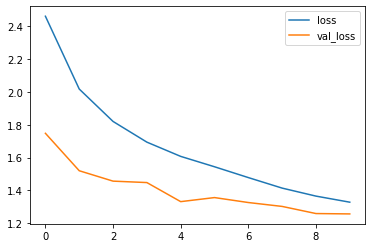

In [46]:
#Plotting Loss
model_df[['loss','val_loss']].plot()

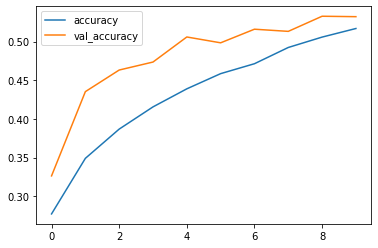

In [47]:
#Plotting accuracy
model_df[['accuracy','val_accuracy']].plot()